# **Task description:**

Provide product sales predictions in order to help to plan stock level.

### Datasets:

**sales.csv**- Data on product-level weekly sales:

- week_starting_date - first day of the week date in format YYYYMMDD
- product_id - unique id for product
- sales - weekly sales in pieces

**categories.csv**- Data on which categories products are assigned to:
- product_id - unique id for product
- category_id - unique id for category

**traffic.csv**:
- week_starting_date - first day of the week date in format YYYYMMDD
- product_id - unique id for product
- traffic - weekly product displays on website'''

### Import Libraries

In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import datetime
import itertools
import seaborn as sns
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from os import listdir
from os.path import isfile, join

rcParams['figure.figsize'] = 10, 6
pd.set_option('display.max_rows', 500)

### Data Collection

In [2]:
# loading the data
mypath = 'data/'
df_categories = pd.read_csv(join(mypath, 'categories.csv'), sep = ';')
df_sales = pd.read_csv(join(mypath, 'sales.csv'), sep = ';', names=["week_when_sold", "product_id", "sales"], parse_dates=['week_when_sold'], header = 0) 
df_traffic = pd.read_csv(join(mypath, 'traffic.csv'), sep = ';', names=["week_when_displayed_on_website", "product_id", "traffic"], parse_dates=['week_when_displayed_on_website'], header = 0)

In [3]:
# getting some information about the data 'categories.csv'
df_categories.info()
print('\n')
df_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   product_id   3135 non-null   int64
 1   category_id  3135 non-null   int64
dtypes: int64(2)
memory usage: 49.1 KB




,product_id,category_id
0,1990,0
1,2361,1
2,1085,2
3,3091,3
4,955,4


In [4]:
# getting some information about the data 'sales.csv'
df_sales.info()
print('\n')
df_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105781 entries, 0 to 105780
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   week_when_sold  105781 non-null  datetime64[ns]
 1   product_id      105781 non-null  int64         
 2   sales           105781 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.4 MB




,week_when_sold,product_id,sales
0,2019-12-09,1990,1
1,2020-11-23,1990,1
2,2020-12-07,1990,1
3,2019-12-02,1990,1
4,2020-11-09,1990,2


In [5]:
# getting some information about the data 'traffic.csv'
df_traffic.info()
print('\n')
df_traffic.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176324 entries, 0 to 176323
Data columns (total 3 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   week_when_displayed_on_website  176324 non-null  datetime64[ns]
 1   product_id                      176324 non-null  int64         
 2   traffic                         176324 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.0 MB




,week_when_displayed_on_website,product_id,traffic
0,2019-01-07,1990,1
1,2019-01-07,2361,7
2,2019-01-07,1085,1
3,2019-01-07,3091,4
4,2019-01-07,955,12


## Preparing the Dataset

In [6]:
df_categories

,product_id,category_id
0,1990,0
1,2361,1
2,1085,2
3,3091,3
4,955,4
...,...,...
3130,2474,18
3131,2638,13
3132,1233,35
3133,567,33


In [7]:
df_sales

,week_when_sold,product_id,sales
0,2019-12-09,1990,1
1,2020-11-23,1990,1
2,2020-12-07,1990,1
3,2019-12-02,1990,1
4,2020-11-09,1990,2
...,...,...,...
105776,2020-10-05,567,9
105777,2020-09-28,567,16
105778,2020-12-07,2643,6
105779,2020-12-14,2643,5


In [8]:
#creating df_data by adding categories to sales
df_data = pd.merge(df_sales, df_categories, on='product_id')
df_data

,week_when_sold,product_id,sales,category_id
0,2019-12-09,1990,1,0
1,2020-11-23,1990,1,0
2,2020-12-07,1990,1,0
3,2019-12-02,1990,1,0
4,2020-11-09,1990,2,0
...,...,...,...,...
105776,2020-10-05,567,9,33
105777,2020-09-28,567,16,33
105778,2020-12-07,2643,6,27
105779,2020-12-14,2643,5,27


In [9]:
# adding traffic info (the same week when sold + the previous week)
df_traffic['week_ago'] = df_traffic['week_when_displayed_on_website'] - datetime.timedelta(days=7)

df_data = pd.merge(df_data, df_traffic[['week_when_displayed_on_website','product_id','traffic']], left_on=['week_when_sold', 'product_id'], right_on=['week_when_displayed_on_website', 'product_id'], how='left').set_axis(df_sales.index)
df_data = pd.merge(df_data, df_traffic[['week_ago','product_id','traffic']], left_on=['week_when_sold', 'product_id'], right_on=['week_ago', 'product_id'], how='left').set_axis(df_sales.index)

In [10]:
df_data.rename(columns = {'week_when_displayed_on_website':'traffic_0_week', 
                          'traffic_x':'amount_traffic_0_week', 
                          'week_ago':'traffic_previous_week', 
                          'traffic_y':'amount_traffic_previous_week'}, inplace = True)
df_data.fillna(0, inplace=True)
df_data.loc[df_data.traffic_0_week != 0, 'traffic_0_week'] = 1
df_data.loc[df_data.traffic_previous_week != 0, 'traffic_previous_week'] = 1
df_data = df_data.astype({'amount_traffic_0_week':'int64', 'amount_traffic_previous_week':'int64'})
df_data

,week_when_sold,product_id,sales,category_id,traffic_0_week,amount_traffic_0_week,traffic_previous_week,amount_traffic_previous_week
0,2019-12-09,1990,1,0,1,1,1,1
1,2020-11-23,1990,1,0,0,0,1,1
2,2020-12-07,1990,1,0,0,0,0,0
3,2019-12-02,1990,1,0,1,1,1,1
4,2020-11-09,1990,2,0,1,1,1,1
...,...,...,...,...,...,...,...,...
105776,2020-10-05,567,9,33,1,64,1,119
105777,2020-09-28,567,16,33,0,0,1,64
105778,2020-12-07,2643,6,27,1,7,1,7
105779,2020-12-14,2643,5,27,1,7,1,2


In [11]:
# adding sales info (sales next week)
df_data['next_week'] = df_data['week_when_sold'] + datetime.timedelta(days=7)
df_data = pd.merge(df_data, df_sales[['week_when_sold','product_id','sales']], left_on=['next_week', 'product_id'], right_on=['week_when_sold', 'product_id'], how='left').set_axis(df_sales.index)

In [12]:
df_data.rename(columns = {'week_when_sold_x':'week_when_sold', 
                          'sales_x':'sales_0_week', 
                          'week_when_sold_y':'sales_the_next_week', 
                          'sales_y':'number_of_sales_the_next_week'}, inplace = True)
df_data.fillna(0, inplace=True)
df_data.loc[df_data.sales_the_next_week != 0, 'sales_the_next_week'] = 1
df_data = df_data.astype({'number_of_sales_the_next_week':'int64'})

In [13]:
df_data

,week_when_sold,product_id,sales_0_week,category_id,traffic_0_week,amount_traffic_0_week,traffic_previous_week,amount_traffic_previous_week,next_week,sales_the_next_week,number_of_sales_the_next_week
0,2019-12-09,1990,1,0,1,1,1,1,2019-12-16,1,2
1,2020-11-23,1990,1,0,0,0,1,1,2020-11-30,1,1
2,2020-12-07,1990,1,0,0,0,0,0,2020-12-14,0,0
3,2019-12-02,1990,1,0,1,1,1,1,2019-12-09,1,1
4,2020-11-09,1990,2,0,1,1,1,1,2020-11-16,0,0
...,...,...,...,...,...,...,...,...,...,...,...
105776,2020-10-05,567,9,33,1,64,1,119,2020-10-12,1,56
105777,2020-09-28,567,16,33,0,0,1,64,2020-10-05,1,9
105778,2020-12-07,2643,6,27,1,7,1,7,2020-12-14,1,5
105779,2020-12-14,2643,5,27,1,7,1,2,2020-12-21,0,0


## Data Exploration

In [14]:
df_data.set_index(df_data['week_when_sold'], inplace=True, drop=True)
df_data.sort_index(inplace=True)
df_data

,week_when_sold,product_id,sales_0_week,category_id,traffic_0_week,amount_traffic_0_week,traffic_previous_week,amount_traffic_previous_week,next_week,sales_the_next_week,number_of_sales_the_next_week
week_when_sold,,,,,,,,,,,
2019-01-07,2019-01-07,3074,2,15,1,3,1,4,2019-01-14,1,4
2019-01-07,2019-01-07,2711,3,23,1,4,1,3,2019-01-14,0,0
2019-01-07,2019-01-07,1034,11,19,1,12,1,13,2019-01-14,1,41
2019-01-07,2019-01-07,1651,9,22,1,3,1,2,2019-01-14,1,14
2019-01-07,2019-01-07,1210,43,30,1,54,1,57,2019-01-14,1,66
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,2020-12-28,2613,6,9,1,8,0,0,2021-01-04,0,0
2020-12-28,2020-12-28,538,58,22,1,12,0,0,2021-01-04,0,0
2020-12-28,2020-12-28,49,14,18,1,1,0,0,2021-01-04,0,0


#### Sales

In [15]:
# The most common products
df_data.product_id.value_counts()

1464    104
838     104
1794    104
554     104
2766    104
       ... 
898       1
91        1
1425      1
2162      1
1939      1
Name: product_id, Length: 2926, dtype: int64

In [16]:
# Top selling products (the highest number of sold items)
_df_data = pd.DataFrame(df_data.groupby(by='product_id')['sales_0_week'].sum()).sort_values('sales_0_week', ascending=False).head(5)
print(_df_data)
print('\n')
print(list(_df_data.index))

            sales_0_week
product_id              
271                88190
1794               61596
414                57358
506                56647
1218               42272


[271, 1794, 414, 506, 1218]


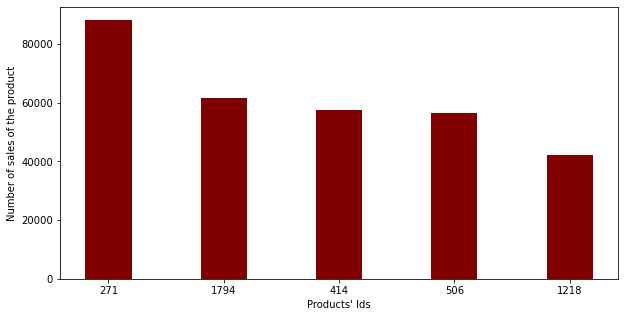

In [17]:
product_id = ['271', '1794', '414', '506', '1218']
sales = list(_df_data.sales_0_week)
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(product_id, sales, color ='maroon',
        width = 0.4)
 
plt.xlabel("Products' Ids")
plt.ylabel("Number of sales of the product")
plt.show()

#### Categories

In [18]:
# The most common categories
df_data.category_id.value_counts().head()

18    5747
5     5199
24    4659
35    4564
4     4275
Name: category_id, dtype: int64

In [19]:
# Top selling products (the highest number of sold items)
_df_categories = pd.DataFrame(df_data.groupby(by='category_id')['sales_0_week'].sum()).sort_values('sales_0_week', ascending=False).head(10)
print(_df_categories)
print('\n')
print(list(_df_categories.index))

             sales_0_week
category_id              
18                 212825
10                 209063
40                 188297
26                 157028
13                 148442
29                 139423
5                  128768
22                 117898
23                 117671
9                  115514


[18, 10, 40, 26, 13, 29, 5, 22, 23, 9]


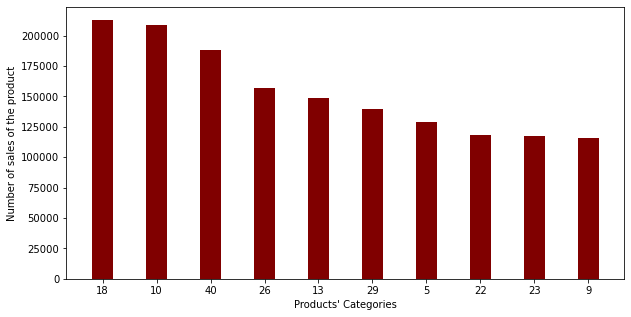

In [20]:
category_id = ['18', '10', '40', '26', '13', '29', '5', '22', '23', '9']

sales = list(_df_categories.sales_0_week)
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(category_id, sales, color ='maroon',
        width = 0.4)
 
plt.xlabel("Products' Categories")
plt.ylabel("Number of sales of the product")
plt.show()

<AxesSubplot:xlabel='week_when_sold', ylabel='sales_0_week'>

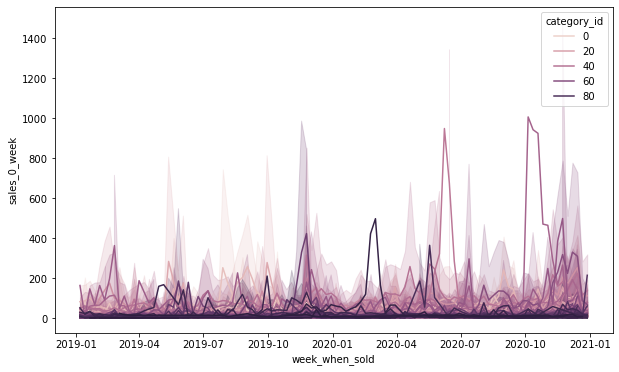

In [21]:
# Sales per categorie in time
sns.lineplot(x=df_data.index, y='sales_0_week', hue='category_id', data=df_data)

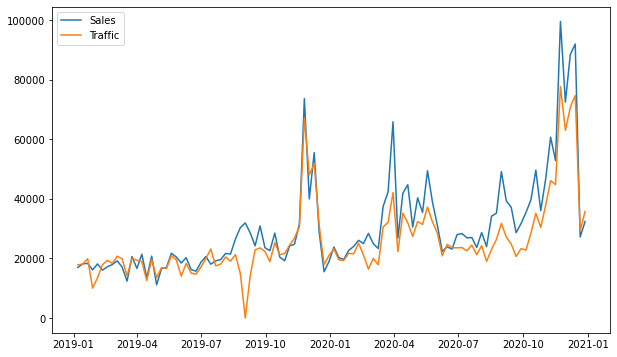

In [22]:
_df_data_sales = pd.DataFrame(df_data.groupby(by=df_data.index)['sales_0_week'].sum())
_df_data_traffic_0 = pd.DataFrame(df_data.groupby(by=df_data.index)['amount_traffic_0_week'].sum())

x1 = _df_data_sales.index
y1 = _df_data_sales.sales_0_week

x2 = _df_data_traffic_0.index
y2 = _df_data_traffic_0.amount_traffic_0_week

plt.plot(x1, y1)
plt.plot(x2, y2)

plt.legend(["Sales", "Traffic"])

## 

## The evaluation metric

In [23]:
def wape(y_true, y_pred):
    return (y_true - y_pred).abs().sum() / y_true.sum()

## Splitting the data

In [24]:
print(min(df_data.index))
print(max(df_data.index))

2019-01-07 00:00:00
2020-12-28 00:00:00


In [25]:
data_train = df_data[df_data.index < '2020-09-01']
data_test = df_data[df_data.index > '2020-09-01']

In [26]:
print(min(data_train.index))
print(max(data_train.index))

2019-01-07 00:00:00
2020-08-31 00:00:00


### Establish the baseline
We can just simply assume to order for the next week the same amount of merchandise that we sold this week. 

In [29]:
y_true = data_train['sales_0_week']
y_pred = data_train['number_of_sales_the_next_week']

In [30]:
wape(y_true, y_pred)

0.6106161374778163